In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import shutil, pathlib
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras import layers
from keras.utils import image_dataset_from_directory

new_base_dir = pathlib.Path("./NewSet")

2025-11-19 19:46:18.513355: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3))
conv_base.summary()

I0000 00:00:1763574381.116050   19727 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4807 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size = (224, 224),
    batch_size = 32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size = (224, 224),
    batch_size = 32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size = (224, 224),
    batch_size = 32)

Found 416 files belonging to 4 classes.
Found 92 files belonging to 4 classes.
Found 92 files belonging to 4 classes.


In [4]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

train_features.shape

2025-11-19 19:46:25.350609: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ceec0005300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-19 19:46:25.350682: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-11-19 19:46:25.402262: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-19 19:46:25.555118: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


I0000 00:00:1763574402.385881   19820 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


2025-11-19 19:46:44.913371: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

2025-11-19 19:46:59.087485: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


(416, 7, 7, 512)

In [5]:
inputs = keras.Input(shape=(7, 7, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20


2025-11-19 19:47:00.297113: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-19 19:47:00.902610: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_568', 32 bytes spill stores, 32 bytes spill loads



13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.7548 - loss: 28.1071 - val_accuracy: 0.9783 - val_loss: 1.1627
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9904 - loss: 0.5665 - val_accuracy: 0.9565 - val_loss: 1.9211
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9904 - loss: 0.1749 - val_accuracy: 0.9674 - val_loss: 3.1679
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9928 - loss: 0.1448 - val_accuracy: 0.9783 - val_loss: 0.9877
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9880 - loss: 0.1911 - val_accuracy: 0.9891 - val_loss: 0.9118
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9928 - loss: 0.0711 - val_accuracy: 0.9565 - val_loss: 1.9462
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9880 - loss: 0.7224 - val_accuracy: 0.9348 - val_loss: 4.5432
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9976 - loss: 0.0566 - val_accuracy: 0.9783 - val_loss: 1.6732

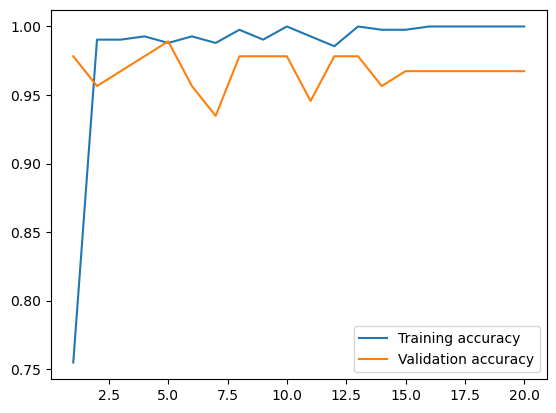

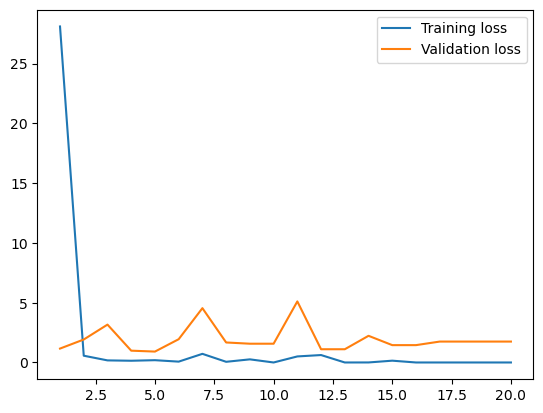

In [6]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = list(range(1, len(accuracy)+1))
plt.plot(epochs, accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.legend()
plt.show()

In [7]:
test_model = keras.models.load_model("feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.9783 - loss: 1.0822
Test accuracy: 0.978


In [8]:
# --- 7. Visualize Errors (Modified for Feature Extraction) ---

print("\n--- Visualizing Errors ---")

# 1. Kerätään kaikki testikuvat muistiin (numpy arrayksi), jotta voimme indeksoida niitä
# Koska shuffle=False, nämä ovat samassa järjestyksessä kuin test_features
all_test_images = []
for img_batch, _ in test_dataset:
    all_test_images.append(img_batch.numpy())
all_test_images = np.concatenate(all_test_images).astype("uint8") # Muutetaan uint8 muotoon näyttöä varten

# 2. Tehdään ennusteet käyttäen jo laskettuja piirteitä (nopeampaa)
predictions = classifier.predict(test_features)
pred_indices = np.argmax(predictions, axis=1)

# 3. Varmistetaan, että test_labels on oikeassa muodossa
true_indices = test_labels.flatten() if len(test_labels.shape) > 1 else test_labels

# 4. Etsitään virheelliset indeksit (missä ennuste != totuus)
error_indices = np.where(pred_indices != true_indices)[0]
print(f"Found {len(error_indices)} errors in total.")

# 5. Piirretään ensimmäiset 10 virhettä (tai vähemmän jos virheitä on vähän)
num_errors_to_show = min(10, len(error_indices))

for k in range(num_errors_to_show):
    idx = error_indices[k] # Haetaan virheen oikea indeksi

    plt.figure(figsize=(8, 3))

    # Kuva (haetaan kerätystä taulukosta indeksillä)
    plt.subplot(1, 2, 1)
    plt.imshow(all_test_images[idx])
    plt.axis('off')

    # Ennusteen todennäköisyydet
    plt.subplot(1, 2, 2)
    probs = predictions[idx]

    # Piirretään palkit
    bars = plt.bar(np.arange(len(class_names)), probs)
    plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha='right')

    # Väritetään oikea vastaus vihreällä ja väärä punaisella
    bars[pred_indices[idx]].set_color('red')
    bars[true_indices[idx]].set_color('green')

    pred_label = class_names[pred_indices[idx]]
    true_label = class_names[true_indices[idx]]

    plt.ylabel("Probability")
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}")
    plt.ylim(0, 1.1) # Pidetään y-akseli vakiona

    plt.tight_layout()
    plt.show()


--- Visualizing Errors ---


2025-11-19 19:47:06.665062: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


NameError: name 'classifier' is not defined